TOTAL

In [ ]:
import yfinance as yf
import pandas as pd

stock = yf.download('AAPL', start='2019-12-20', end='2024-02-10')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
full_date_range = pd.date_range(start=stock.index.min(), end=stock.index.max())
closed_market_days = full_date_range.difference(stock.index)

In [ ]:
df_bert = pd.read_csv('apple_bert.csv')
df_finbert = pd.read_csv('apple_finbert.csv')

In [ ]:
df_bert = df_bert.drop(columns=['Unnamed: 0'])
df_finbert = df_finbert.drop(columns=['Unnamed: 0'])
stock = stock[~stock.index.isin(closed_market_days)]
stock['Stock_Price_Change'] = stock['Close'].diff()
stock.dropna()

,Open,High,Low,Close,Adj Close,Volume,Stock_Price_Change
Date,,,,,,,
2019-12-23,70.132500,71.062500,70.092499,71.000000,68.988762,98572000,1.139999
2019-12-24,71.172501,71.222504,70.730003,71.067497,69.054344,48478800,0.067497
2019-12-26,71.205002,72.495003,71.175003,72.477501,70.424393,93121200,1.410004
2019-12-27,72.779999,73.492500,72.029999,72.449997,70.397675,146266000,-0.027504
2019-12-30,72.364998,73.172501,71.305000,72.879997,70.815483,144114400,0.430000
...,...,...,...,...,...,...,...
2024-02-05,188.149994,189.250000,185.839996,187.679993,187.186920,69668800,1.829987
2024-02-06,186.860001,189.309998,186.770004,189.300003,188.802673,43490800,1.620010
2024-02-07,190.639999,191.050003,188.610001,189.410004,188.912399,53439000,0.110001


In [ ]:
# Convert the published date to datetime format if not already done
df_bert['published'] = pd.to_datetime(df_bert['published'], format='%a, %d %b %Y %H:%M:%S GMT')
df_finbert['published'] = pd.to_datetime(df_finbert['published'], format='%a, %d %b %Y %H:%M:%S GMT')

# Extract date part only for merging and convert to datetime64[ns] type
df_bert['published_date'] = pd.to_datetime(df_bert['published'].dt.date)
df_finbert['published_date'] = pd.to_datetime(df_finbert['published'].dt.date)

bert finbert granger gruplandırmadan

In [ ]:
df_bert['published_date'] = pd.to_datetime(df_bert['published_date'])
df_finbert['published_date'] = pd.to_datetime(df_finbert['published_date'])

# Correct the merge statements
df_bert = df_bert.merge(stock[['Stock_Price_Change', 'Volume']], left_on='published_date', right_index=True)
df_finbert = df_finbert.merge(stock[['Stock_Price_Change', 'Volume']], left_on='published_date', right_index=True)

In [ ]:
def numeric_score_bert(row):
  if row['sentiment'] == 'POSITIVE':
    return row['sentiment_score']
  elif row['sentiment'] == 'NEGATIVE':
    return -row['sentiment_score']
  else:
    return 0
df_bert['numeric_score'] = df_bert.apply(numeric_score_bert, axis=1)

In [ ]:
def numeric_score_finbert(row):
  if row['sentiment'] == 'Positive':
    return row['sentiment_score']
  elif row['sentiment'] == 'Negative':
    return -row['sentiment_score']
  else:
    return 0
df_finbert['numeric_score'] = df_finbert.apply(numeric_score_finbert, axis=1)

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

df_granger_bert = df_bert[['numeric_score', 'Stock_Price_Change']].dropna()
df_granger_finbert = df_finbert[['numeric_score', 'Stock_Price_Change']].dropna()

# Perform Granger Causality Test for BERT sentiment scores
max_lag = 15  # You can choose an appropriate lag
print("Granger Causality Test for BERT Sentiment Scores")
granger_results_bert = grangercausalitytests(df_granger_bert, max_lag, verbose=True)

# Perform Granger Causality Test for FinBERT sentiment scores
print("\nGranger Causality Test for FinBERT Sentiment Scores")
granger_results_finbert = grangercausalitytests(df_granger_finbert, max_lag, verbose=True)

# Interpret results
def interpret_granger_results(granger_results):
    for lag, test_result in granger_results.items():
        f_test_p_value = test_result[0]['ssr_ftest'][1]
        print(f'Lag {lag}: F-test p-value = {f_test_p_value}')

print("\nInterpreting Granger Causality Test Results for BERT")
interpret_granger_results(granger_results_bert)

print("\nInterpreting Granger Causality Test Results for FinBERT")
interpret_granger_results(granger_results_finbert)

Granger Causality Test for BERT Sentiment Scores

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3380  , p=0.0677  , df_denom=10773, df_num=1
ssr based chi2 test:   chi2=3.3389  , p=0.0677  , df=1
likelihood ratio test: chi2=3.3384  , p=0.0677  , df=1
parameter F test:         F=3.3380  , p=0.0677  , df_denom=10773, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6324  , p=0.0265  , df_denom=10770, df_num=2
ssr based chi2 test:   chi2=7.2681  , p=0.0264  , df=2
likelihood ratio test: chi2=7.2657  , p=0.0264  , df=2
parameter F test:         F=3.6324  , p=0.0265  , df_denom=10770, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5522  , p=0.0537  , df_denom=10767, df_num=3
ssr based chi2 test:   chi2=7.6616  , p=0.0535  , df=3
likelihood ratio test: chi2=7.6589  , p=0.0536  , df=3
parameter F test:         F=2.5522  , p=0.0537  , df_denom=10767, df_num=3

Granger Causality
number of lags

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=2.0574  , p=0.0548  , df_denom=10758, df_num=6
ssr based chi2 test:   chi2=12.3590 , p=0.0544  , df=6
likelihood ratio test: chi2=12.3519 , p=0.0546  , df=6
parameter F test:         F=2.0574  , p=0.0548  , df_denom=10758, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.8062  , p=0.0814  , df_denom=10755, df_num=7
ssr based chi2 test:   chi2=12.6611 , p=0.0808  , df=7
likelihood ratio test: chi2=12.6537 , p=0.0810  , df=7
parameter F test:         F=1.8062  , p=0.0814  , df_denom=10755, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.6079  , p=0.1168  , df_denom=10752, df_num=8
ssr based chi2 test:   chi2=12.8834 , p=0.1159  , df=8
likelihood ratio test: chi2=12.8757 , p=0.1162  , df=8
parameter F test:         F=1.6079  , p=0.1168  , df_denom=10752, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.7467  , p=0.0731  , df_denom=10749, df_num=9
ssr bas

BERT Sentiment Scores: Granger causality is observed at lags 2 and 5, with p-values indicating significance. Other lags show marginal or no significance.

FinBERT Sentiment Scores: Granger causality is observed consistently from lag 1 through lag 11, with p-values indicating strong significance. Marginal significance is seen at lags 12 and 13, while lags 14 and 15 show no significance.

These results suggest that FinBERT sentiment scores have a stronger and more consistent predictive power for stock price changes compared to BERT sentiment scores

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

df_granger_bert_vol = df_bert[['Stock_Price_Change', 'Volume']].dropna()
df_granger_finbert_vol = df_finbert[['Stock_Price_Change', 'Volume']].dropna()

# Perform Granger Causality Test for BERT sentiment scores
max_lag = 15  # You can choose an appropriate lag
print("Granger Causality Test for BERT Sentiment Scores")
granger_results_bert_vol = grangercausalitytests(df_granger_bert_vol, max_lag, verbose=True)

# Perform Granger Causality Test for FinBERT sentiment scores
print("\nGranger Causality Test for FinBERT Sentiment Scores")
granger_results_finbert_vol = grangercausalitytests(df_granger_finbert_vol, max_lag, verbose=True)

# Interpret results
def interpret_granger_results(granger_results):
    for lag, test_result in granger_results.items():
        f_test_p_value = test_result[0]['ssr_ftest'][1]
        print(f'Lag {lag}: F-test p-value = {f_test_p_value}')

print("\nInterpreting Granger Causality Test Results for BERT")
interpret_granger_results(granger_results_bert_vol)

print("\nInterpreting Granger Causality Test Results for FinBERT")
interpret_granger_results(granger_results_finbert_vol)

Granger Causality Test for BERT Sentiment Scores

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3801  , p=0.5376  , df_denom=10773, df_num=1
ssr based chi2 test:   chi2=0.3802  , p=0.5375  , df=1
likelihood ratio test: chi2=0.3802  , p=0.5375  , df=1
parameter F test:         F=0.3801  , p=0.5376  , df_denom=10773, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2464  , p=0.7816  , df_denom=10770, df_num=2
ssr based chi2 test:   chi2=0.4931  , p=0.7815  , df=2
likelihood ratio test: chi2=0.4931  , p=0.7815  , df=2
parameter F test:         F=0.2464  , p=0.7816  , df_denom=10770, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1528  , p=0.9280  , df_denom=10767, df_num=3
ssr based chi2 test:   chi2=0.4586  , p=0.9279  , df=3
likelihood ratio test: chi2=0.4586  , p=0.9279  , df=3
parameter F test:         F=0.1528  , p=0.9280  , df_denom=10767, df_num=3

Granger Causality
number of lags

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=4.0007  , p=0.0002  , df_denom=10755, df_num=7
ssr based chi2 test:   chi2=28.0441 , p=0.0002  , df=7
likelihood ratio test: chi2=28.0077 , p=0.0002  , df=7
parameter F test:         F=4.0007  , p=0.0002  , df_denom=10755, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.5530  , p=0.0004  , df_denom=10752, df_num=8
ssr based chi2 test:   chi2=28.4689 , p=0.0004  , df=8
likelihood ratio test: chi2=28.4313 , p=0.0004  , df=8
parameter F test:         F=3.5530  , p=0.0004  , df_denom=10752, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.3107  , p=0.0005  , df_denom=10749, df_num=9
ssr based chi2 test:   chi2=29.8491 , p=0.0005  , df=9
likelihood ratio test: chi2=29.8078 , p=0.0005  , df=9
parameter F test:         F=3.3107  , p=0.0005  , df_denom=10749, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.2685  , p=0.0003  , df_denom=10746, df_num=10
ssr b

VAR-BERT

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 23, May, 2024
Time:                     17:12:36
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  0.0589748
Nobs:                     10768.0    HQIC:                 0.0419380
Log likelihood:          -30699.4    FPE:                    1.03383
AIC:                    0.0332685    Det(Omega_mle):         1.03019
--------------------------------------------------------------------
Results for equation Stock_Price_Change
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.016215         0.014625            1.109           0.268
L1.Stock_Price_Change         0.946994         0.009644           98.193           0.000
L1.numeric_scor

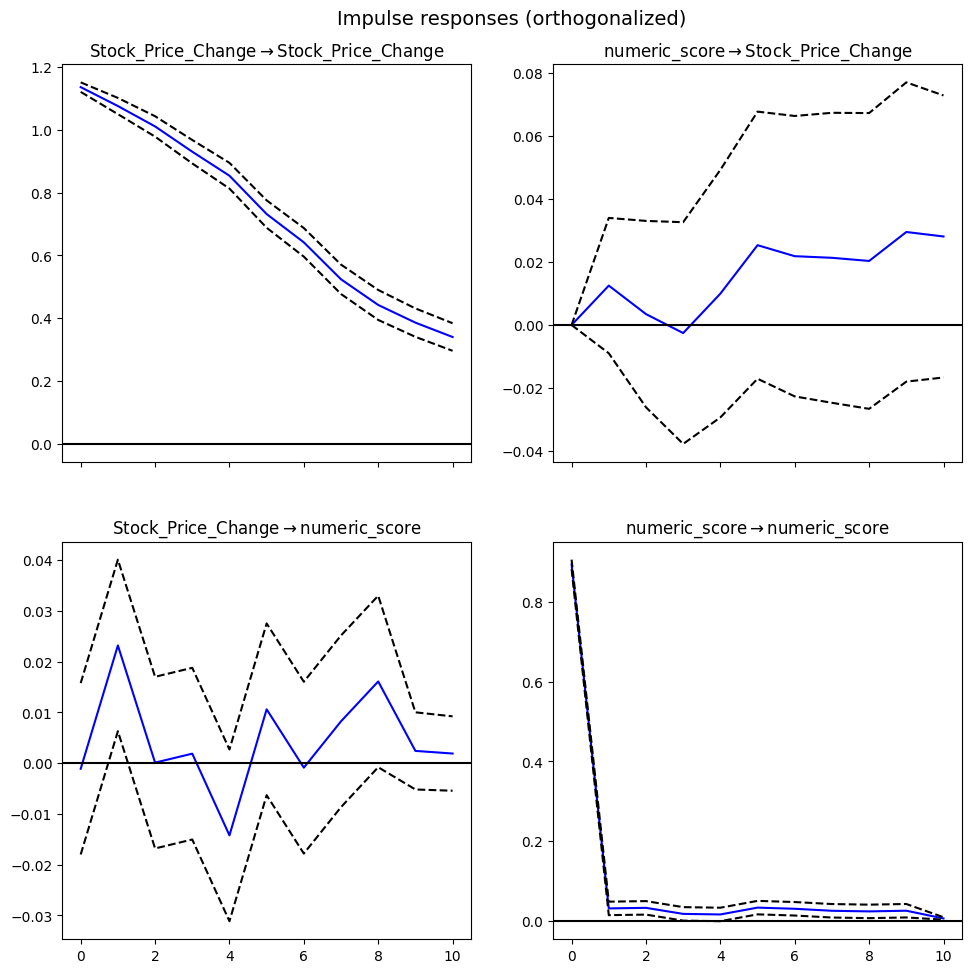

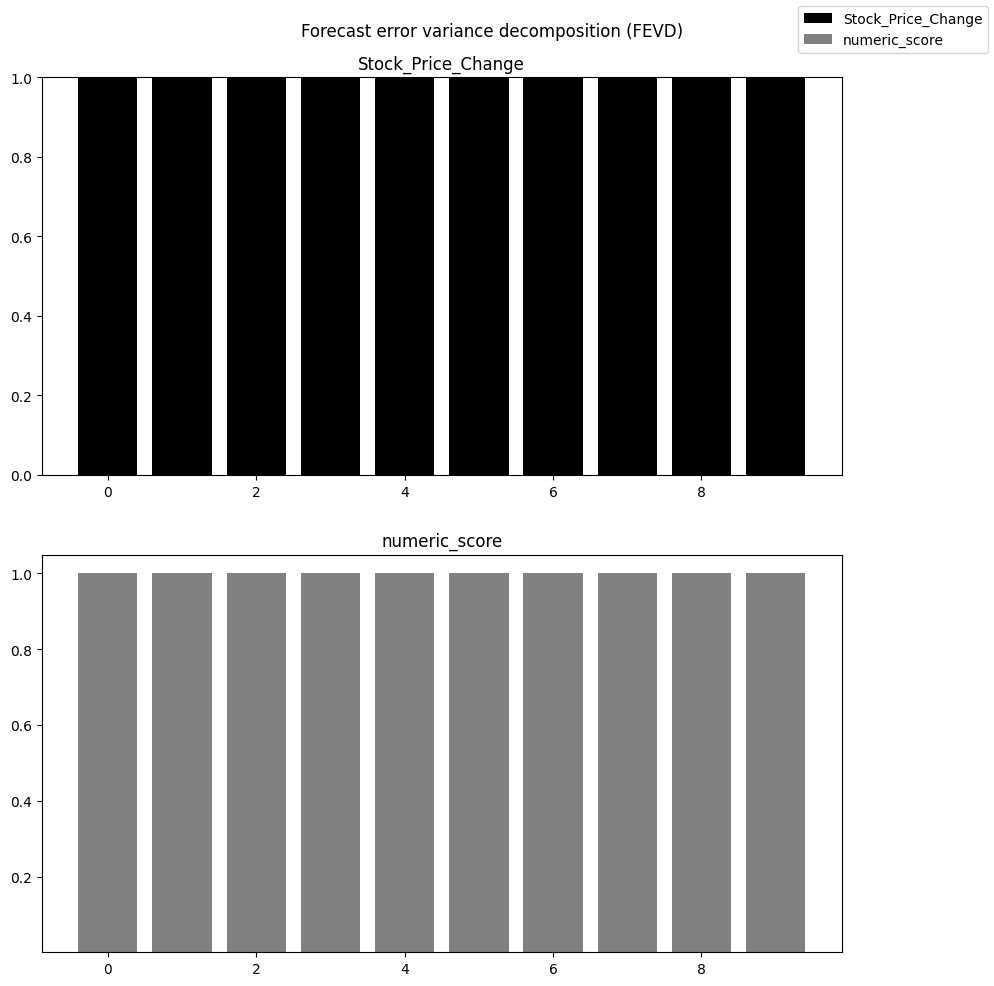

In [ ]:
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# Prepare the data for VAR model
# Using differenced stock prices and original FinBERT sentiment scores
var_data = df_bert[['Stock_Price_Change', 'numeric_score']].dropna()

# Fit the VAR model
model = VAR(var_data)
results = model.fit(maxlags=15, ic='aic')

# Summary of the model
print(results.summary())

# Impulse Response Function
irf = results.irf(10)
irf.plot(orth=True)
plt.show()

# Forecast Error Variance Decomposition
fevd = results.fevd(10)
fevd.plot()
plt.show()


The Stock_Price_Change series shows strong persistence with significant autoregressive terms.

The impact of numeric_score on Stock_Price_Change is minor and mostly insignificant.

The numeric_score series also shows persistence, with several lags being significant.

Impulse response functions and FEVD plots indicate that Stock_Price_Change is primarily influenced by its own past values, whereas numeric_score has a lesser impact on Stock_Price_Change.

These findings suggest that while there is some interaction between stock price changes and numeric scores, the primary driving factor for stock price changes is their own past values.

VAR-FinBERT

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 23, May, 2024
Time:                     17:12:42
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.11713
Nobs:                     10762.0    HQIC:                  -1.14494
Log likelihood:          -24242.2    FPE:                   0.313772
AIC:                     -1.15909    Det(Omega_mle):        0.311972
--------------------------------------------------------------------
Results for equation Stock_Price_Change
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                          0.004269         0.010955            0.390           0.697
L1.Stock_Price_Change          0.946394         0.009648           98.087           0.000
L1.numeric_

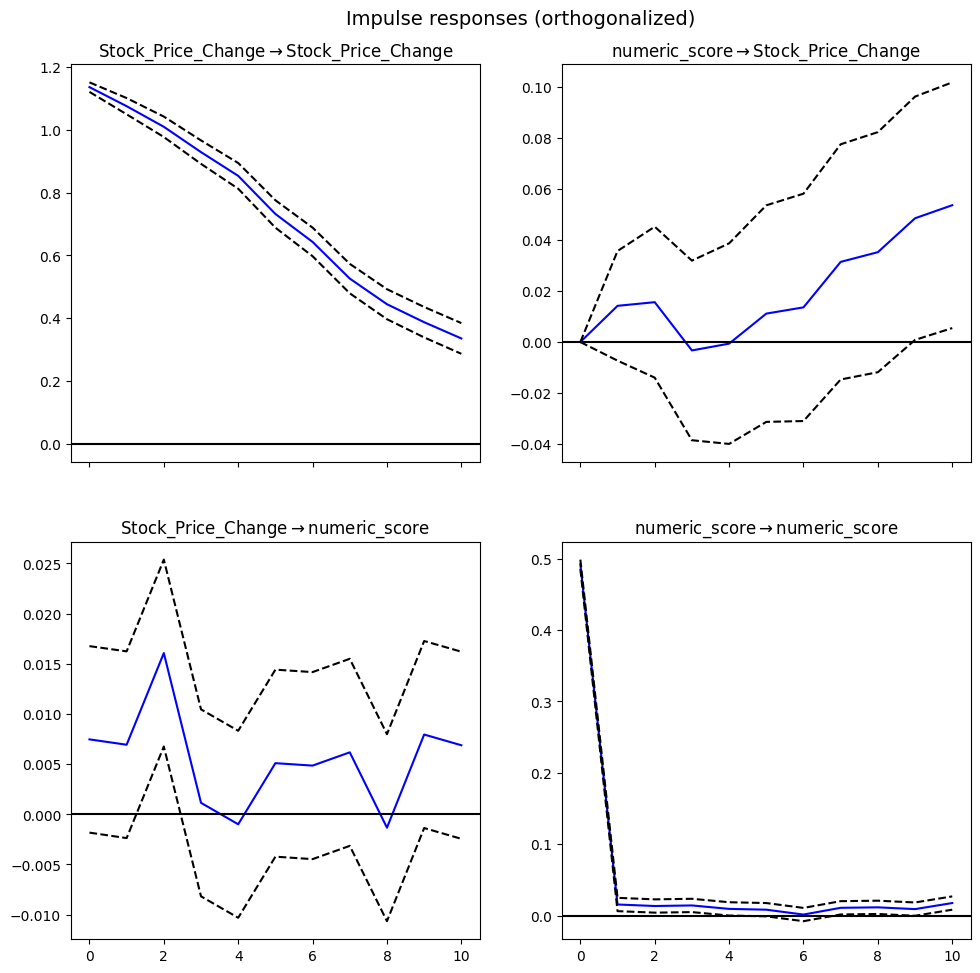

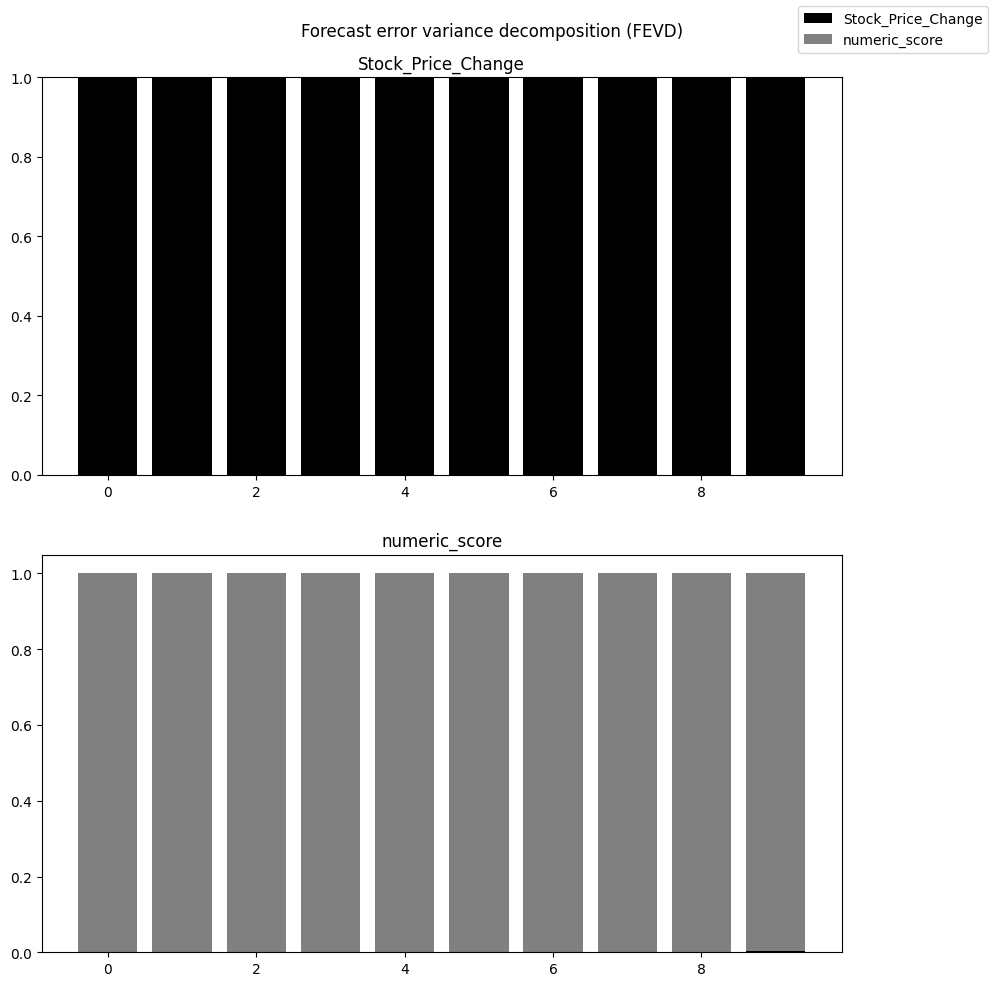

In [ ]:
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# Prepare the data for VAR model
# Using differenced stock prices and original FinBERT sentiment scores
var_data = df_finbert[['Stock_Price_Change', 'numeric_score']].dropna()

# Fit the VAR model
model = VAR(var_data)
results = model.fit(maxlags=15, ic='aic')

# Summary of the model
print(results.summary())

# Impulse Response Function
irf = results.irf(10)
irf.plot(orth=True)
plt.show()

# Forecast Error Variance Decomposition
fevd = results.fevd(10)
fevd.plot()
plt.show()


The second model exhibits a slightly better relationship between numeric_score and Stock_Price_Change based on the following observations:

The L15.numeric_score is significant in the Stock_Price_Change equation, indicating a delayed negative effect. The impulse response function shows a small positive effect of numeric_score on Stock_Price_Change over time, which is not present in the first model. The forecast error variance decomposition shows a slightly higher influence of numeric_score on Stock_Price_Change in the second model. Thus, the second model might be more promising for predicting Stock_Price_Change using numeric_score due to the presence of some significant coefficients and a more noticeable impact in the IRF. However, the overall influence of numeric_score remains limited, and the primary driver of Stock_Price_Change is still its own past values.

First Model:

Stock_Price_Change: Lags 1, 5, and 7.

numeric_score: Potentially exclude or include cautiously based on further diagnostics.

Second Model:

Stock_Price_Change: Lags 1, 5, 7, and 15. numeric_score: Lags 1, 3, 7, and especially 15.

FinBERT PREDICTION

RandomForest

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

lags = [1, 3, 5, 7, 15]
for lag in lags:
    df_finbert[f'Stock_Price_Change_lag{lag}'] = df_finbert['Stock_Price_Change'].shift(lag)
    df_finbert[f'numeric_score_lag{lag}'] = df_finbert['numeric_score'].shift(lag)

df_finbert.dropna(inplace=True)

features = [f'Stock_Price_Change_lag{lag}' for lag in lags] + [f'numeric_score_lag{lag}' for lag in lags]
target = 'Stock_Price_Change'

X = df_finbert[features]
y = df_finbert[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Training a Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Predicting on the test set
y_pred = model_rf.predict(X_test)

# Calculating the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# You can also calculate other metrics if needed, such as R-squared
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Mean Squared Error: 1.5348351979405335
R-squared: 0.7965279565286365


An R-squared value close to 1 indicates that the model explains a significant portion of the variance in the target variable. This suggests that the model is performing well.

GridSearchCV ile hyperparametre finetuning

In [ ]:
# Initialize the Random Forest model with the best parameters
final_model = RandomForestRegressor(
    bootstrap=True,
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=10,
    n_estimators=200,
    random_state=42
)

# Train the final model on the training data
final_model.fit(X_train, y_train)

# Predict on the test set
y_pred_final = final_model.predict(X_test)

# Calculate the Mean Squared Error and R-squared
mse_final = mean_squared_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print(f'Final Model Mean Squared Error: {mse_final}')
print(f'Final Model R-squared: {r2_final}')

Final Model Mean Squared Error: 1.2750906862931675
Final Model R-squared: 0.8309621072676063


XGBoost

In [ ]:
from xgboost import XGBRegressor

# Initialize and train an XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate the XGBoost model
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost Mean Squared Error: {mse_xgb}')
print(f'XGBoost R-squared: {r2_xgb}')

XGBoost Mean Squared Error: 1.4496992217612232
XGBoost R-squared: 0.8078143741644697


RF XGBoosttan daha iyi

RF Feauture Importance

In [ ]:
importances = final_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                    Feature  Importance
0   Stock_Price_Change_lag1    0.945607
3   Stock_Price_Change_lag7    0.011441
4  Stock_Price_Change_lag15    0.009822
2   Stock_Price_Change_lag5    0.006260
9       numeric_score_lag15    0.005879
6        numeric_score_lag3    0.005192
7        numeric_score_lag5    0.004244
8        numeric_score_lag7    0.004080
5        numeric_score_lag1    0.003865
1   Stock_Price_Change_lag3    0.003609


LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score


lags = [1, 3, 5, 7, 15]
for lag in lags:
    df_finbert[f'Stock_Price_Change_lag{lag}'] = df_finbert['Stock_Price_Change'].shift(lag)
    df_finbert[f'numeric_score_lag{lag}'] = df_finbert['numeric_score'].shift(lag)

df_finbert.dropna(inplace=True)

features = [f'Stock_Price_Change_lag{lag}' for lag in lags] + [f'numeric_score_lag{lag}' for lag in lags]
target = 'Stock_Price_Change'

X = df_finbert[features]
y = df_finbert[target]

# Scaling the features
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Reshaping the data to 3D format for LSTM: [samples, time steps, features]
X_scaled_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_reshaped, y, test_size=0.2, random_state=42)

# Building the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1))

# Compiling the model
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Training the model
history = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Predicting on the test set
y_pred = model_lstm.predict(X_test)

# Calculating the Mean Squared Error and R-squared
mse_lstm = mean_squared_error(y_test, y_pred)
r2_lstm = r2_score(y_test, y_pred)

print(f'LSTM Mean Squared Error: {mse_lstm}')
print(f'LSTM R-squared: {r2_lstm}')


Epoch 1/20
215/215 [==============================] - 8s 11ms/step - loss: 6.1619 - val_loss: 3.0818
Epoch 2/20
215/215 [==============================] - 1s 6ms/step - loss: 2.1615 - val_loss: 1.7516
Epoch 3/20
215/215 [==============================] - 1s 5ms/step - loss: 1.6773 - val_loss: 1.5681
Epoch 4/20
215/215 [==============================] - 1s 6ms/step - loss: 1.5514 - val_loss: 1.5159
Epoch 5/20
215/215 [==============================] - 1s 6ms/step - loss: 1.4922 - val_loss: 1.4037
Epoch 6/20
215/215 [==============================] - 1s 5ms/step - loss: 1.4631 - val_loss: 1.3896
Epoch 7/20
215/215 [==============================] - 1s 6ms/step - loss: 1.4303 - val_loss: 1.4288
Epoch 8/20
215/215 [==============================] - 3s 15ms/step - loss: 1.4229 - val_loss: 1.3515
Epoch 9/20
215/215 [==============================] - 3s 16ms/step - loss: 1.4061 - val_loss: 1.3714
Epoch 10/20
215/215 [==============================] - 2s 11ms/step - loss: 1.3957 - val_loss: 1.

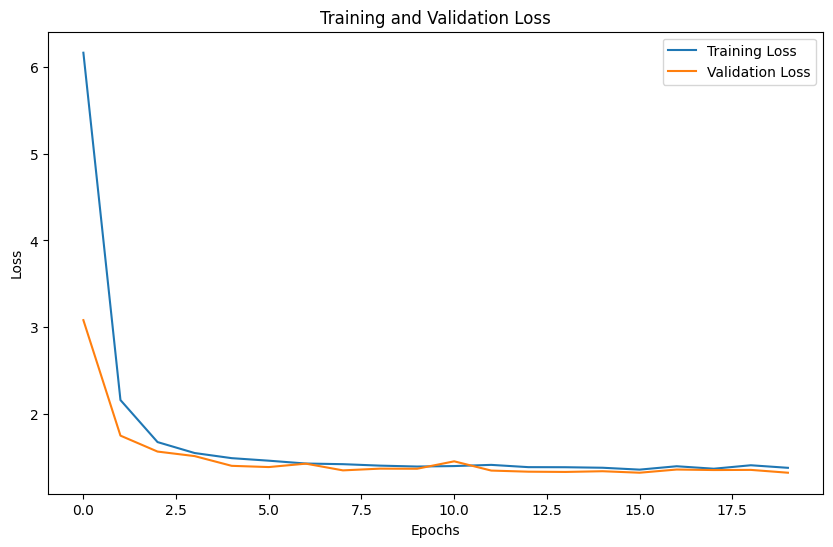

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

If the validation loss starts increasing while the training loss continues to decrease, it is a sign of overfitting.



The plot suggests that your LSTM model is performing well with good generalization capabilities. Both training and validation losses have decreased significantly and stabilized, indicating that the model has effectively learned from the data without overfitting. You might consider using early stopping around the point where the losses stabilize to optimize training time.

In [ ]:
# Predict on training set
y_train_pred = model_lstm.predict(X_train)

# Calculate the Mean Squared Error and R-squared for training set
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print(f'Training Mean Squared Error: {mse_train}')
print(f'Training R-squared: {r2_train}')

# Predict on test set
y_test_pred = model_lstm.predict(X_test)

# Calculate the Mean Squared Error and R-squared for test set
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Test Mean Squared Error: {mse_test}')
print(f'Test R-squared: {r2_test}')


269/269 [==============================] - 1s 2ms/step
Training Mean Squared Error: 1.3377550499912778
Training R-squared: 0.8159632020639198
68/68 [==============================] - 0s 3ms/step
Test Mean Squared Error: 1.1595354128218884
Test R-squared: 0.8317270901535323


If the performance metrics on the training set are significantly better than those on the test set, the model is likely overfitting.

The performance metrics indicate that your LSTM model has been trained effectively and generalizes well to new, unseen data. The high R-squared values and consistent MSE between training and test sets suggest that the model has captured the essential patterns in the data without overfitting. This is a good sign that the model can be trusted to make reliable predictions on similar data in the future.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data with lag features
lags = [1, 3, 5, 7, 15]
for lag in lags:
    df_finbert[f'Stock_Price_Change_lag{lag}'] = df_finbert['Stock_Price_Change'].shift(lag)
    df_finbert[f'numeric_score_lag{lag}'] = df_finbert['numeric_score'].shift(lag)

df_finbert.dropna(inplace=True)

features = [f'Stock_Price_Change_lag{lag}' for lag in lags] + [f'numeric_score_lag{lag}' for lag in lags]
target = 'Stock_Price_Change'

X = df_finbert[features]
y = df_finbert[target]

# Reset the index to ensure continuous indices
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# Scaling the features
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Reshaping the data to 3D format for LSTM: [samples, time steps, features]
X_scaled_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []
r2_scores = []

for train_index, test_index in kf.split(X_scaled_reshaped):
    X_train, X_test = X_scaled_reshaped[train_index], X_scaled_reshaped[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Build the LSTM model
    model_lstm = Sequential()
    model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model_lstm.add(LSTM(units=50))
    model_lstm.add(Dense(1))

    # Compile the model
    model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train the model
    model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

    # Predict on the test set
    y_pred = model_lstm.predict(X_test)

    # Calculate the Mean Squared Error and R-squared
    mse_lstm = mean_squared_error(y_test, y_pred)
    r2_lstm = r2_score(y_test, y_pred)

    mse_scores.append(mse_lstm)
    r2_scores.append(r2_lstm)

# Calculate the average and standard deviation of the scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f'Average LSTM Mean Squared Error: {mean_mse} ± {std_mse}')
print(f'Average LSTM R-squared: {mean_r2} ± {std_r2}')


68/68 [==============================] - 1s 2ms/step
Average LSTM Mean Squared Error: 1.3495554233684979 ± 0.20406378682509818
Average LSTM R-squared: 0.8119520986697417 ± 0.030391676055870745


The model demonstrates good performance, with a high R-squared value and a reasonable MSE.
The low standard deviations for both MSE and R-squared indicate that the model's performance is stable and reliable across different subsets of the data.
This consistency and relatively high explanatory power suggest that the LSTM model is effective in capturing the patterns in the stock price change data based on the given features.

Prediction BERT

Random Forest

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

lags = [1, 5, 7]
for lag in lags:
    df_bert[f'Stock_Price_Change_lag{lag}'] = df_bert['Stock_Price_Change'].shift(lag)
    df_bert[f'numeric_score_lag{lag}'] = df_bert['numeric_score'].shift(lag)

df_bert.dropna(inplace=True)

features = [f'Stock_Price_Change_lag{lag}' for lag in lags] + [f'numeric_score_lag{lag}' for lag in lags]
target = 'Stock_Price_Change'

X = df_bert[features]
y = df_bert[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Training a Random Forest Regressor
model_rf_bert = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_bert.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Predicting on the test set
y_pred = model_rf_bert.predict(X_test)

# Calculating the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# You can also calculate other metrics if needed, such as R-squared
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Mean Squared Error: 1.5468525211874042
R-squared: 0.793073113967107


In [ ]:
# Initialize the Random Forest model with the best parameters
final_model_bert = RandomForestRegressor(
    bootstrap=True,
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=10,
    n_estimators=200,
    random_state=42
)

# Train the final model on the training data
final_model_bert.fit(X_train, y_train)

# Predict on the test set
y_pred_final = final_model_bert.predict(X_test)

# Calculate the Mean Squared Error and R-squared
mse_final = mean_squared_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print(f'Final Model Mean Squared Error: {mse_final}')
print(f'Final Model R-squared: {r2_final}')

Final Model Mean Squared Error: 1.4251673893422774
Final Model R-squared: 0.8093512820951749


In [ ]:
from xgboost import XGBRegressor

# Initialize and train an XGBoost model
xgb_model_bert = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model_bert.fit(X_train, y_train)

# Predict and evaluate the XGBoost model
y_pred_xgb = xgb_model_bert.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost Mean Squared Error: {mse_xgb}')
print(f'XGBoost R-squared: {r2_xgb}')

XGBoost Mean Squared Error: 1.5639208456298974
XGBoost R-squared: 0.7907898353879875


In [ ]:
importances = final_model_bert.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                   Feature  Importance
0  Stock_Price_Change_lag1    0.944223
5       numeric_score_lag7    0.013041
3       numeric_score_lag1    0.012101
4       numeric_score_lag5    0.011978
2  Stock_Price_Change_lag7    0.010782
1  Stock_Price_Change_lag5    0.007875


LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score


lags = [1, 5, 7]
for lag in lags:
    df_bert[f'Stock_Price_Change_lag{lag}'] = df_bert['Stock_Price_Change'].shift(lag)
    df_bert[f'numeric_score_lag{lag}'] = df_bert['numeric_score'].shift(lag)

df_bert.dropna(inplace=True)

features = [f'Stock_Price_Change_lag{lag}' for lag in lags] + [f'numeric_score_lag{lag}' for lag in lags]
target = 'Stock_Price_Change'

X = df_bert[features]
y = df_bert[target]

# Scaling the features
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Reshaping the data to 3D format for LSTM: [samples, time steps, features]
X_scaled_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_reshaped, y, test_size=0.2, random_state=42)

# Building the LSTM model
model_lstm_bert = Sequential()
model_lstm_bert.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm_bert.add(LSTM(units=50))
model_lstm_bert.add(Dense(1))

# Compiling the model
model_lstm_bert.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Training the model
history = model_lstm_bert.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Predicting on the test set
y_pred = model_lstm_bert.predict(X_test)

# Calculating the Mean Squared Error and R-squared
mse_lstm = mean_squared_error(y_test, y_pred)
r2_lstm = r2_score(y_test, y_pred)

print(f'LSTM Mean Squared Error: {mse_lstm}')
print(f'LSTM R-squared: {r2_lstm}')


Epoch 1/20
216/216 [==============================] - 8s 10ms/step - loss: 6.1239 - val_loss: 3.9057
Epoch 2/20
216/216 [==============================] - 1s 6ms/step - loss: 2.0140 - val_loss: 1.8706
Epoch 3/20
216/216 [==============================] - 1s 6ms/step - loss: 1.5944 - val_loss: 1.5889
Epoch 4/20
216/216 [==============================] - 1s 6ms/step - loss: 1.4871 - val_loss: 1.5070
Epoch 5/20
216/216 [==============================] - 1s 6ms/step - loss: 1.4001 - val_loss: 1.5173
Epoch 6/20
216/216 [==============================] - 1s 5ms/step - loss: 1.3655 - val_loss: 1.4597
Epoch 7/20
216/216 [==============================] - 2s 8ms/step - loss: 1.3464 - val_loss: 1.4765
Epoch 8/20
216/216 [==============================] - 2s 9ms/step - loss: 1.3376 - val_loss: 1.4252
Epoch 9/20
216/216 [==============================] - 2s 8ms/step - loss: 1.3192 - val_loss: 1.4167
Epoch 10/20
216/216 [==============================] - 3s 12ms/step - loss: 1.3224 - val_loss: 1.42

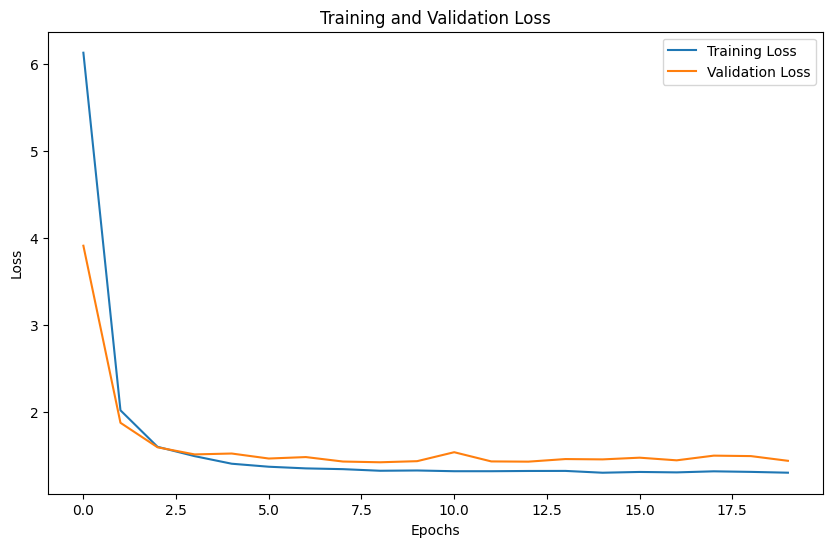

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Predict on training set
y_train_pred = model_lstm_bert.predict(X_train)

# Calculate the Mean Squared Error and R-squared for training set
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print(f'Training Mean Squared Error: {mse_train}')
print(f'Training R-squared: {r2_train}')

# Predict on test set
y_test_pred = model_lstm_bert.predict(X_test)

# Calculate the Mean Squared Error and R-squared for test set
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Test Mean Squared Error: {mse_test}')
print(f'Test R-squared: {r2_test}')


270/270 [==============================] - 1s 3ms/step
Training Mean Squared Error: 1.3133302908911413
Training R-squared: 0.8145438192647387
68/68 [==============================] - 0s 2ms/step
Test Mean Squared Error: 1.314164273064901
Test R-squared: 0.8272433437611832


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score

lags = [1, 5, 7]
for lag in lags:
    df_bert[f'Stock_Price_Change_lag{lag}'] = df_bert['Stock_Price_Change'].shift(lag)
    df_bert[f'numeric_score_lag{lag}'] = df_bert['numeric_score'].shift(lag)

df_bert.dropna(inplace=True)

features = [f'Stock_Price_Change_lag{lag}' for lag in lags] + [f'numeric_score_lag{lag}' for lag in lags]
target = 'Stock_Price_Change'

X = df_bert[features]
y = df_bert[target]

# Reset the index to ensure continuous indices
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# Scaling the features
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Reshaping the data to 3D format for LSTM: [samples, time steps, features]
X_scaled_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []
r2_scores = []

for train_index, test_index in kf.split(X_scaled_reshaped):
    X_train, X_test = X_scaled_reshaped[train_index], X_scaled_reshaped[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Build the LSTM model
    model_lstm_bert = Sequential()
    model_lstm_bert.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model_lstm_bert.add(LSTM(units=50))
    model_lstm_bert.add(Dense(1))

    # Compile the model
    model_lstm_bert.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train the model
    model_lstm_bert.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

    # Predict on the test set
    y_pred = model_lstm_bert.predict(X_test)

    # Calculate the Mean Squared Error and R-squared
    mse_lstm = mean_squared_error(y_test, y_pred)
    r2_lstm = r2_score(y_test, y_pred)

    mse_scores.append(mse_lstm)
    r2_scores.append(r2_lstm)

# Calculate the average and standard deviation of the scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f'Average LSTM Mean Squared Error: {mean_mse} ± {std_mse}')
print(f'Average LSTM R-squared: {mean_r2} ± {std_r2}')


68/68 [==============================] - 1s 2ms/step
Average LSTM Mean Squared Error: 1.3816176470652746 ± 0.20546503126054752
Average LSTM R-squared: 0.8073429055207582 ± 0.03072037860619876


LDA

bert

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    processed_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    processed_text = ' '.join(processed_tokens)

    return processed_text

df_bert['processed_headlines'] = df_bert['title'].apply(preprocess_text)
df_finbert['processed_headlines'] = df_finbert['title'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert text data to document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df_bert['processed_headlines'])

# Check the shape of the document-term matrix
print(dtm.shape)  # (number of documents, number of features/terms)

(10756, 5178)


In [ ]:
n_topics = 10

lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(dtm)

topic_distributions = lda.transform(dtm)

terms = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    print(f"Top 10 words for topic #{i}:")
    print([terms[i] for i in topic.argsort()[-10:]])
    print("\n")

Top 10 words for topic #0:
['korea', 'company', 'sell', 'auction', 'wozniak', 'computer', 'cofounder', 'job', 'steve', 'apple']


Top 10 words for topic #1:
['report', 'customer', 'company', 'service', 'probe', 'stop', 'say', 'iphones', 'working', 'apple']


Top 10 words for topic #2:
['amazon', 'world', 'hit', 'microsoft', 'tech', 'trillion', 'stock', 'company', 'market', 'apple']


Top 10 words for topic #3:
['growth', 'aapl', 'year', 'best', 'price', 'share', 'buy', 'nasdaqaapl', 'stock', 'apple']


Top 10 words for topic #4:
['unveils', 'iphone', 'mac', 'macbook', 'headset', 'new', 'chip', 'vision', 'pro', 'apple']


Top 10 words for topic #5:
['return', 'earnings', '500', 'class', 'action', 'aapl', 'startup', 'pay', 'million', 'apple']


Top 10 words for topic #6:
['lawsuit', 'store', 'covering', 'today', 'watch', 'patent', 'ceo', 'tim', 'cook', 'apple']


Top 10 words for topic #7:
['meta', 'developer', 'user', 'antitrust', 'game', 'epic', 'google', 'app', 'store', 'apple']


Top

In [ ]:
for i in range(n_topics):
    df_bert[f'topic_{i}'] = topic_distributions[:, i]

# Check the updated dataframe
print(df_bert.head())

                                                title           published  \
30   $5 billion Foxconn plant deal scrapped: Minister 2020-01-07 08:00:00   
31      Apple suddenly leaks crazy new iPhone details 2020-01-07 08:00:00   
32  Defining the decade: ten years of Apple on one... 2020-01-07 08:00:00   
33  Apple's App Store had gross sales around $50 b... 2020-01-08 08:00:00   
34  Ok, Google: How many people use Assistant mont... 2020-01-08 08:00:00   

                source                                               link  \
30           The Hindu  https://news.google.com/rss/articles/CBMieWh0d...   
31       The Asian Age  https://news.google.com/rss/articles/CBMiamh0d...   
32             9to5Mac  https://news.google.com/rss/articles/CBMiMWh0d...   
33                CNBC  https://news.google.com/rss/articles/CBMiZGh0d...   
34  The Economic Times  https://news.google.com/rss/articles/CBMigQFod...   

   published_date                                      cleaned_title  \
30

In [ ]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df_finbert['processed_headlines'])

n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(dtm)

topic_distributions = lda.transform(dtm)

terms = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    print(f"Top 10 words for topic #{i}:")
    print([terms[i] for i in topic.argsort()[-10:]])
    print("\n")

Top 10 words for topic #0:
['big', 'share', 'company', 'aapl', 'trillion', 'nasdaqaapl', 'tech', 'market', 'stock', 'apple']


Top 10 words for topic #1:
['2023', 'air', 'chip', 'new', 'macbook', 'headset', 'mac', 'vision', 'pro', 'apple']


Top 10 words for topic #2:
['sale', 'steve', 'job', 'update', 'ban', 'auction', 'io', 'computer', 'watch', 'apple']


Top 10 words for topic #3:
['plant', '14', 'foxconn', 'maker', 'iphones', 'sale', 'chip', 'india', 'iphone', 'apple']


Top 10 words for topic #4:
['musk', 'india', 'job', 'say', 'world', 'ceo', 'tim', 'company', 'cook', 'apple']


Top 10 words for topic #5:
['price', '12', '14', 'event', 'launch', 'pro', '15', 'new', 'apple', 'iphone']


Top 10 words for topic #6:
['antitrust', 'chief', 'say', 'car', 'game', 'epic', 'google', 'app', 'store', 'apple']


Top 10 words for topic #7:
['say', 'lawsuit', 'wozniak', 'new', 'million', 'cofounder', 'google', 'job', 'steve', 'apple']


Top 10 words for topic #8:
['plan', 'supply', 'today', 'i

In [ ]:
for i in range(n_topics):
    df_finbert[f'topic_{i}'] = topic_distributions[:, i]

# Check the updated dataframe
print(df_finbert.head())

                                                title           published  \
63  Apple Is Moving Past the iPhone. Here's Why Th... 2020-01-13 08:00:00   
64  Pensacola shooting was an act of terrorism, at... 2020-01-13 08:00:00   
65  Apple Won't Help the FBI Unlock a Terrorist's ... 2020-01-14 08:00:00   
66  US patents hit record 333,530 granted in 2019;... 2020-01-14 08:00:00   
67  Apple Wins Patent for a Possible Future MacBoo... 2020-01-14 08:00:00   

                 source                                               link  \
63                 Inc.  https://news.google.com/rss/articles/CBMiWmh0d...   
64  The Washington Post  https://news.google.com/rss/articles/CBMirAFod...   
65                 Inc.  https://news.google.com/rss/articles/CBMiaGh0d...   
66           TechCrunch  https://news.google.com/rss/articles/CBMieGh0d...   
67       Patently Apple  https://news.google.com/rss/articles/CBMiiAFod...   

   published_date                                      cleaned_title

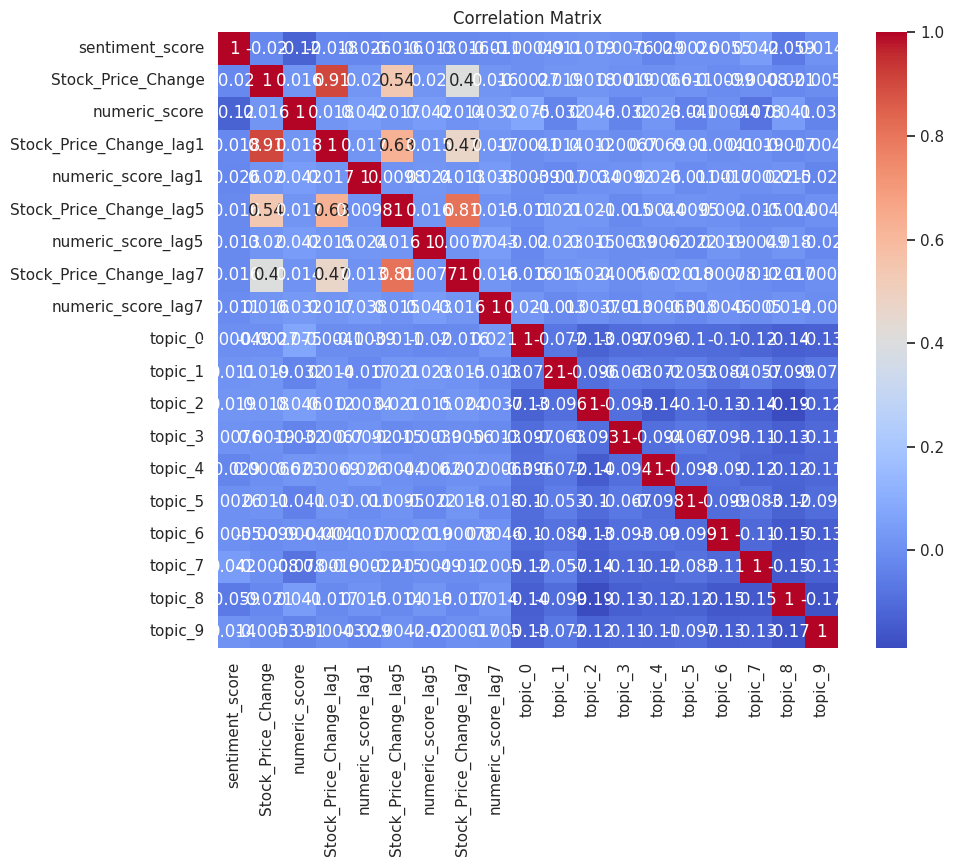

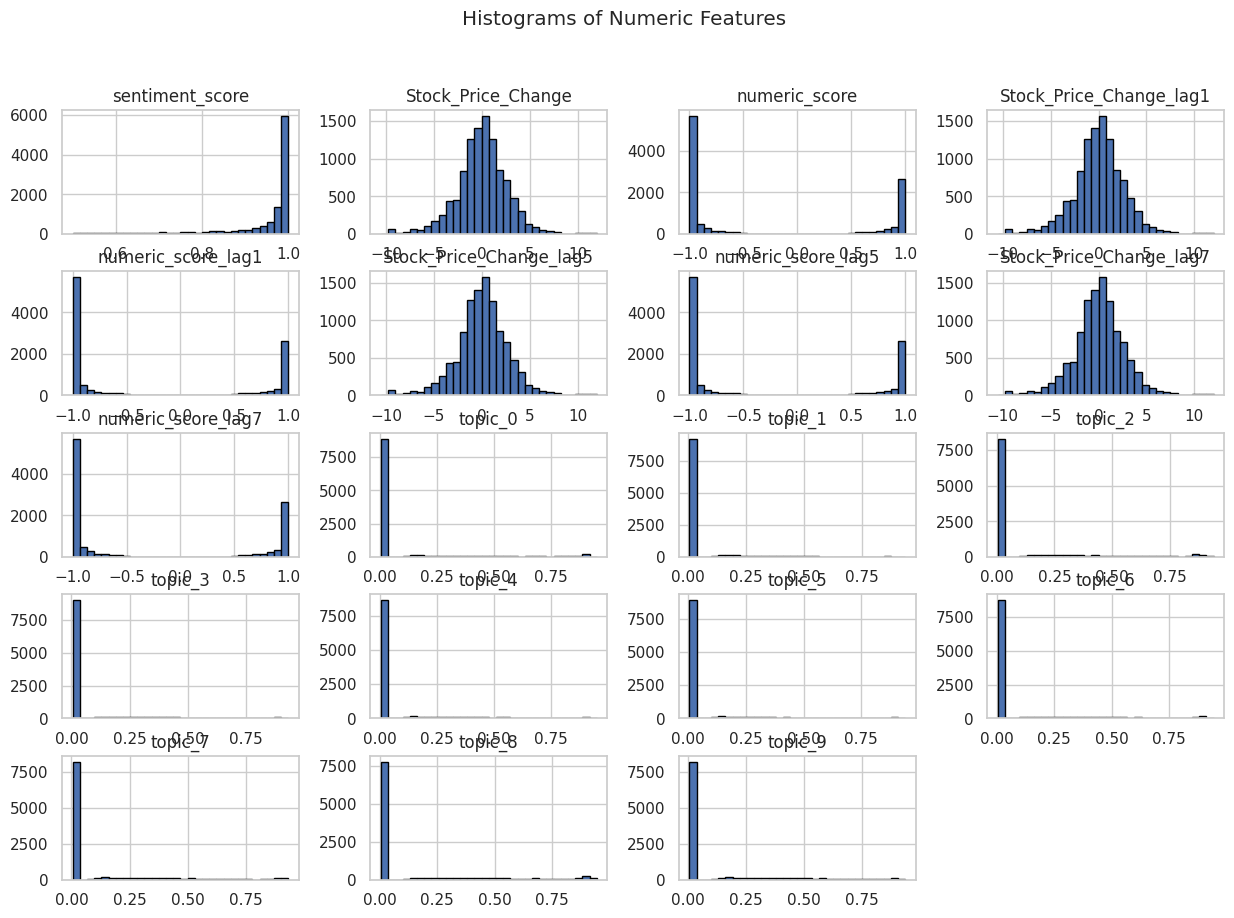

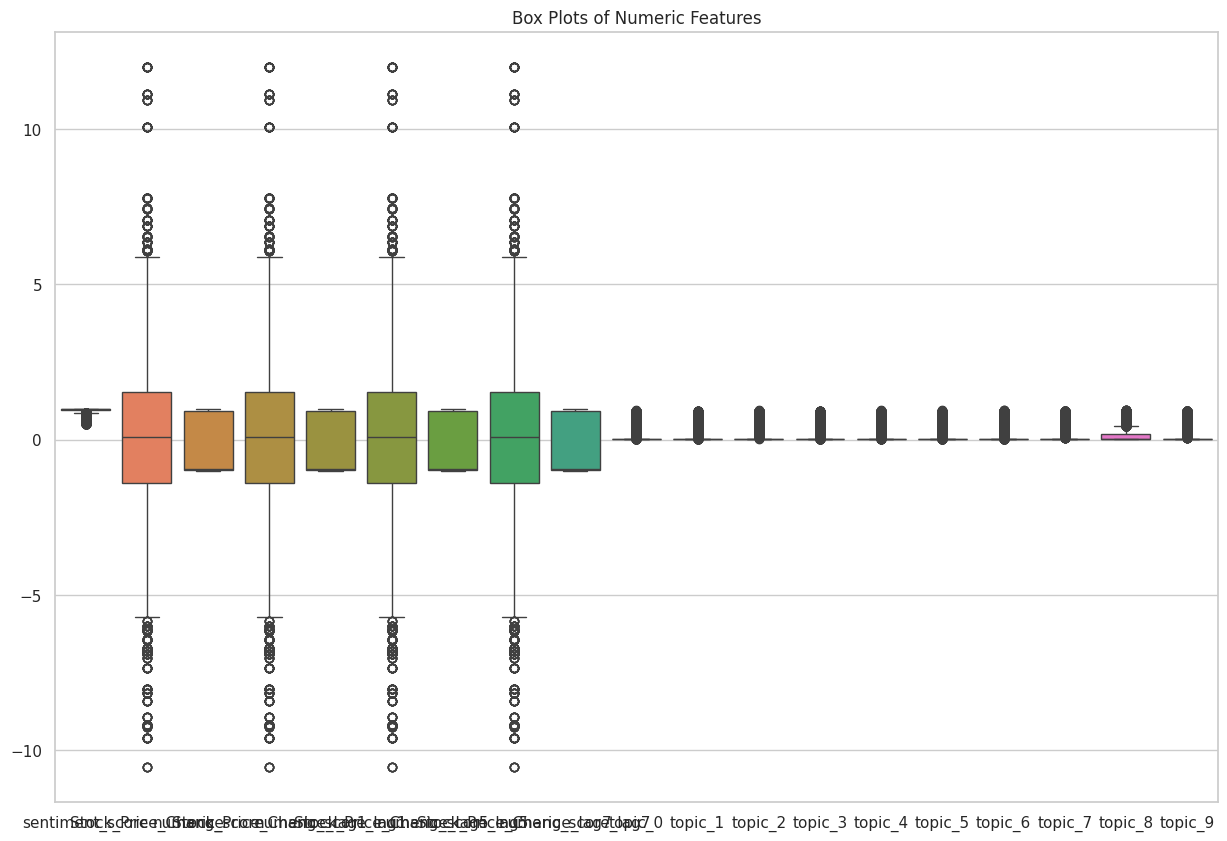

In [ ]:
numeric_data = df_bert.select_dtypes(include=[np.number])

correlation_matrix = numeric_data.corr()

import matplotlib.pyplot as plt
import seaborn as sns

# Set the visualisation style
sns.set(style='whitegrid')

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Histogram of numeric features
numeric_data.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle('Histograms of Numeric Features')
plt.show()

# Box plots to identify outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=numeric_data)
plt.title('Box Plots of Numeric Features')
plt.show()



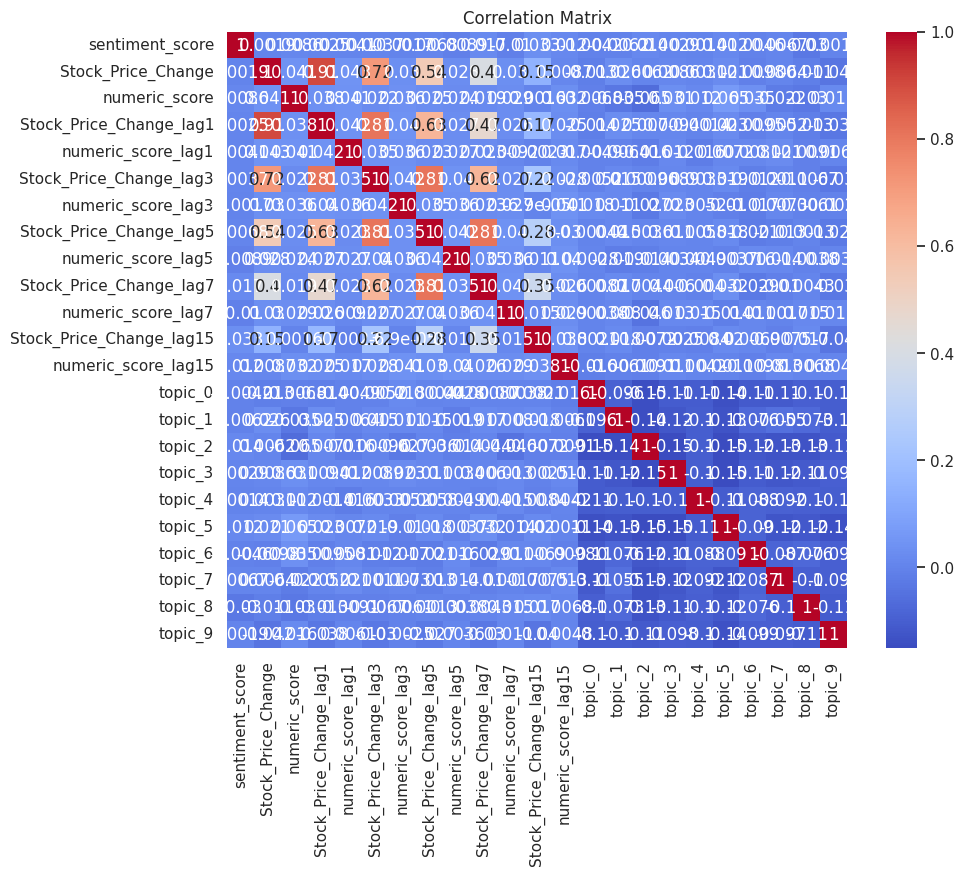

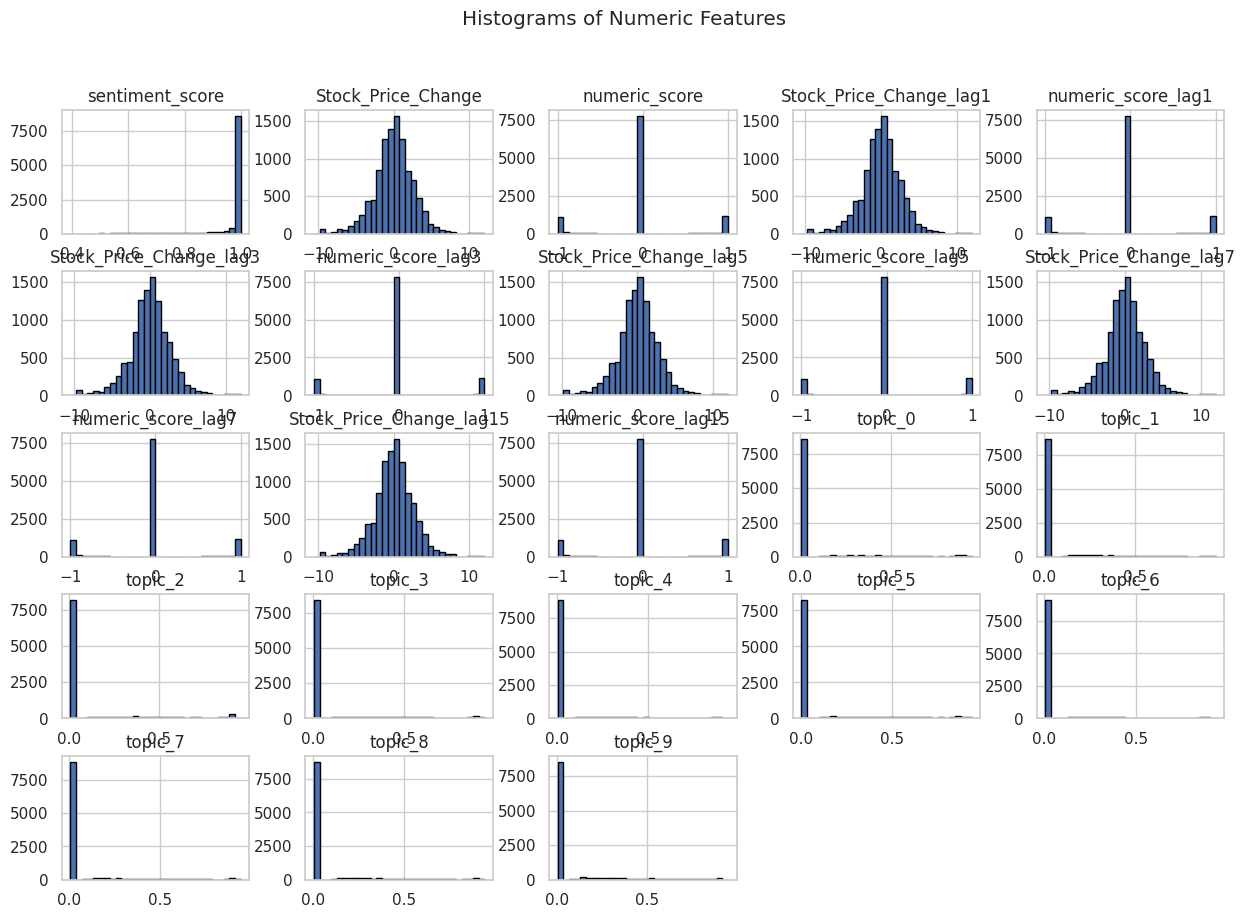

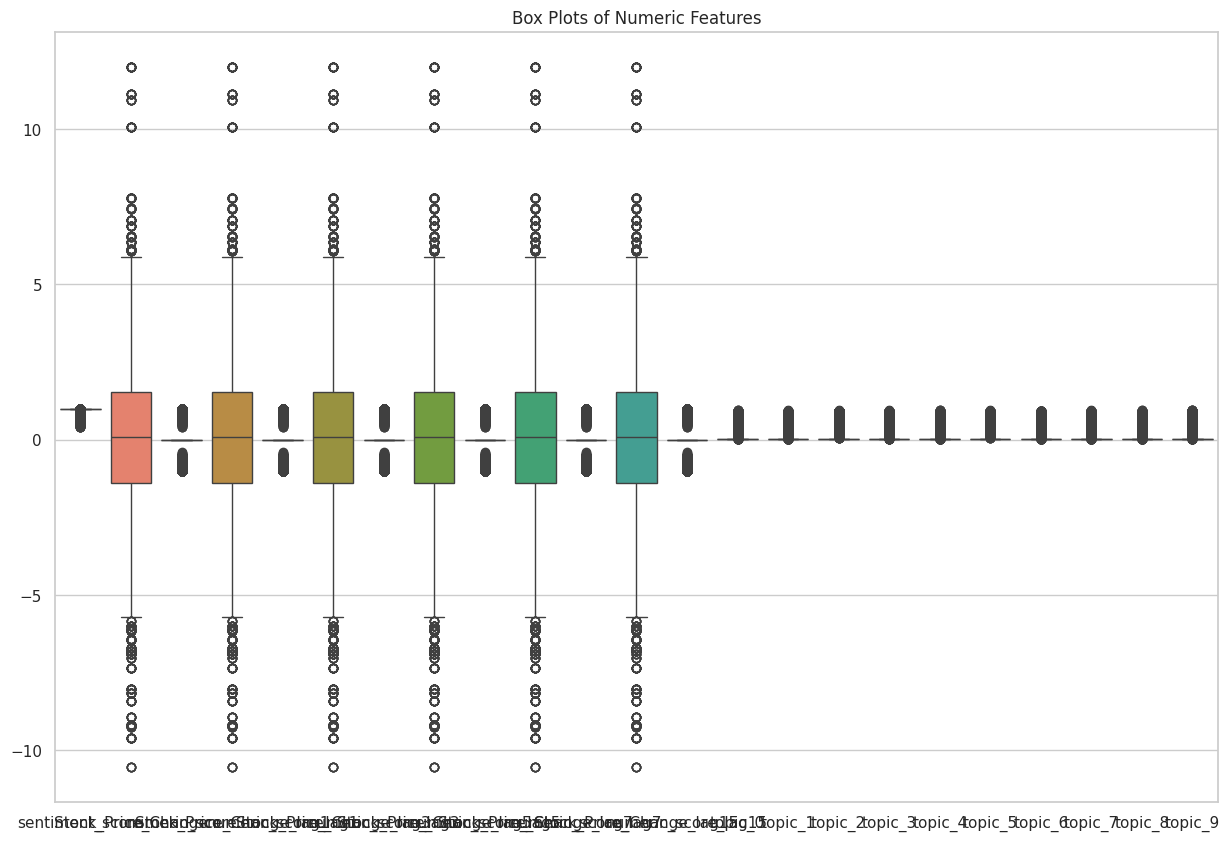

In [ ]:
numeric_data = df_finbert.select_dtypes(include=[np.number])

correlation_matrix = numeric_data.corr()

import matplotlib.pyplot as plt
import seaborn as sns

# Set the visualisation style
sns.set(style='whitegrid')

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Histogram of numeric features
numeric_data.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle('Histograms of Numeric Features')
plt.show()

# Box plots to identify outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=numeric_data)
plt.title('Box Plots of Numeric Features')
plt.show()



In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

lags = [1, 3, 5, 7, 15]
for lag in lags:
    df_finbert[f'Stock_Price_Change_lag{lag}'] = df_finbert['Stock_Price_Change'].shift(lag)
    df_finbert[f'numeric_score_lag{lag}'] = df_finbert['numeric_score'].shift(lag)

df_finbert.dropna(inplace=True)
X = df_finbert[[f'topic_{i}' for i in range(10)] + [f'Stock_Price_Change_lag{lag}' for lag in lags] + [f'numeric_score_lag{lag}' for lag in lags]]  # Example features
y = df_finbert['Stock_Price_Change']  # Example target variable

# Scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(X)

# Create sequences for LSTM
def create_sequences(data, target, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Length of the sequences
X, y = create_sequences(scaled_features, df_finbert[target].values, seq_length)

# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20
174/174 [==============================] - 10s 21ms/step - loss: 7.2498 - val_loss: 6.9845
Epoch 2/20
174/174 [==============================] - 3s 15ms/step - loss: 5.6984 - val_loss: 5.3774
Epoch 3/20
174/174 [==============================] - 4s 24ms/step - loss: 4.5584 - val_loss: 4.2612
Epoch 4/20
174/174 [==============================] - 4s 23ms/step - loss: 4.0092 - val_loss: 3.4081
Epoch 5/20
174/174 [==============================] - 3s 16ms/step - loss: 3.7367 - val_loss: 3.2373
Epoch 6/20
174/174 [==============================] - 3s 16ms/step - loss: 3.5341 - val_loss: 3.6405
Epoch 7/20
174/174 [==============================] - 3s 16ms/step - loss: 3.5277 - val_loss: 3.2374
Epoch 8/20
174/174 [==============================] - 4s 21ms/step - loss: 3.4953 - val_loss: 3.3964
Epoch 9/20
174/174 [==============================] - 4s 20ms/step - loss: 3.3943 - val_loss: 3.3632
Epoch 10/20
174/174 [==============================] - 3s 16ms/step - loss: 3.3817 - val_l

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse_lstm = mean_squared_error(y_test, y_pred)
r2_lstm = r2_score(y_test, y_pred)

print(f"LSTM - Mean Squared Error: {mse_lstm}")
print(f"LSTM - R-squared: {r2_lstm}")

55/55 [==============================] - 1s 6ms/step
LSTM - Mean Squared Error: 1.4649492546239766
LSTM - R-squared: 0.7695589001140677


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

lags = [1, 3, 5, 7, 15]
for lag in lags:
    df_finbert[f'Stock_Price_Change_lag{lag}'] = df_finbert['Stock_Price_Change'].shift(lag)
    df_finbert[f'numeric_score_lag{lag}'] = df_finbert['numeric_score'].shift(lag)

df_finbert.dropna(inplace=True)
X = df_finbert[[f'topic_{i}' for i in range(10)] + [f'Stock_Price_Change_lag{lag}' for lag in lags] + [f'numeric_score_lag{lag}' for lag in lags]]  # Example features
y = df_finbert['Stock_Price_Change']  # Example target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "SVR": SVR()
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "R²": r2}

# Add the LSTM results
results["LSTM"] = {"MSE": mse_lstm, "R²": r2_lstm}

# Print the results
results_df = pd.DataFrame(results).T
print(results_df)

                        MSE        R²
Linear Regression  1.563241  0.808434
Ridge Regression   1.563220  0.808437
Lasso Regression   1.725542  0.788545
Random Forest      1.675163  0.794719
XGBoost            1.840656  0.774439
SVR                1.883770  0.769156
LSTM               1.464949  0.769559


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

lags = [1, 3, 5, 7, 15]
for lag in lags:
    df_bert[f'Stock_Price_Change_lag{lag}'] = df_bert['Stock_Price_Change'].shift(lag)
    df_bert[f'numeric_score_lag{lag}'] = df_bert['numeric_score'].shift(lag)

df_bert.dropna(inplace=True)
X = df_bert[[f'topic_{i}' for i in range(10)] + [f'Stock_Price_Change_lag{lag}' for lag in lags] + [f'numeric_score_lag{lag}' for lag in lags]]  # Example features
y = df_bert['Stock_Price_Change']  # Example target variable

# Scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(X)

# Create sequences for LSTM
def create_sequences(data, target, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Length of the sequences
X, y = create_sequences(scaled_features, df_bert[target].values, seq_length)

# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20
175/175 [==============================] - 8s 21ms/step - loss: 7.4123 - val_loss: 7.7683
Epoch 2/20
175/175 [==============================] - 3s 15ms/step - loss: 6.2744 - val_loss: 5.6839
Epoch 3/20
175/175 [==============================] - 4s 22ms/step - loss: 4.8150 - val_loss: 4.1288
Epoch 4/20
175/175 [==============================] - 3s 18ms/step - loss: 4.1015 - val_loss: 3.3137
Epoch 5/20
175/175 [==============================] - 5s 27ms/step - loss: 3.6786 - val_loss: 3.3681
Epoch 6/20
175/175 [==============================] - 5s 30ms/step - loss: 3.5714 - val_loss: 3.2806
Epoch 7/20
175/175 [==============================] - 6s 32ms/step - loss: 3.4096 - val_loss: 3.1070
Epoch 8/20
175/175 [==============================] - 6s 33ms/step - loss: 3.4669 - val_loss: 3.6151
Epoch 9/20
175/175 [==============================] - 3s 19ms/step - loss: 3.3818 - val_loss: 3.1309
Epoch 10/20
175/175 [==============================] - 4s 24ms/step - loss: 3.2969 - val_lo

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse_lstm = mean_squared_error(y_test, y_pred)
r2_lstm = r2_score(y_test, y_pred)

print(f"LSTM - Mean Squared Error: {mse_lstm}")
print(f"LSTM - R-squared: {r2_lstm}")

55/55 [==============================] - 1s 6ms/step
LSTM - Mean Squared Error: 1.5865050175085187
LSTM - R-squared: 0.7479186792074848


Sentiment Aggregation - FinBERT

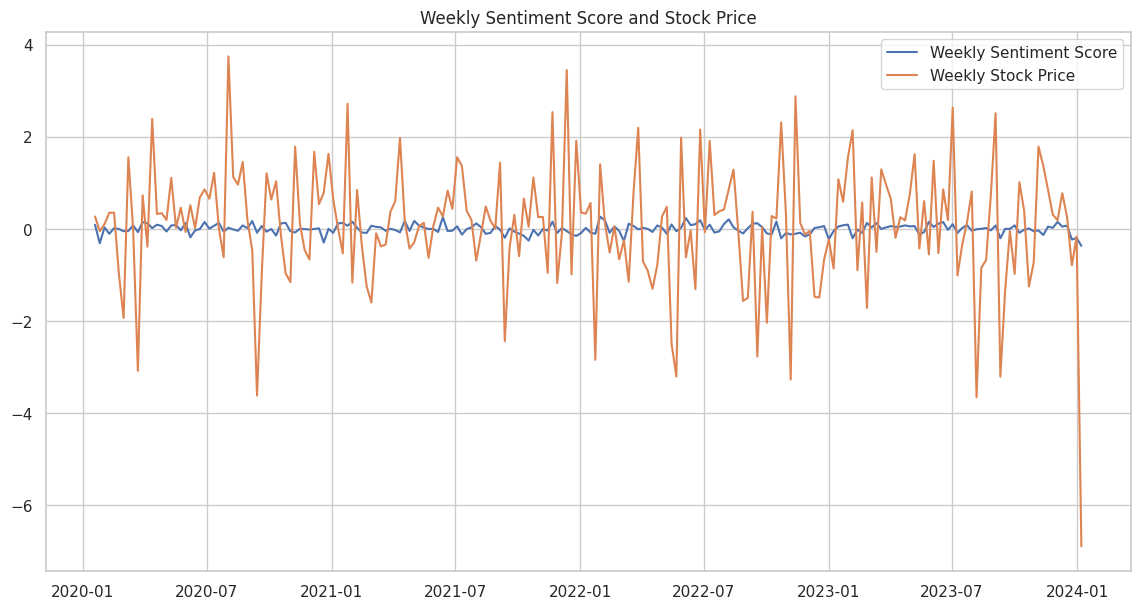

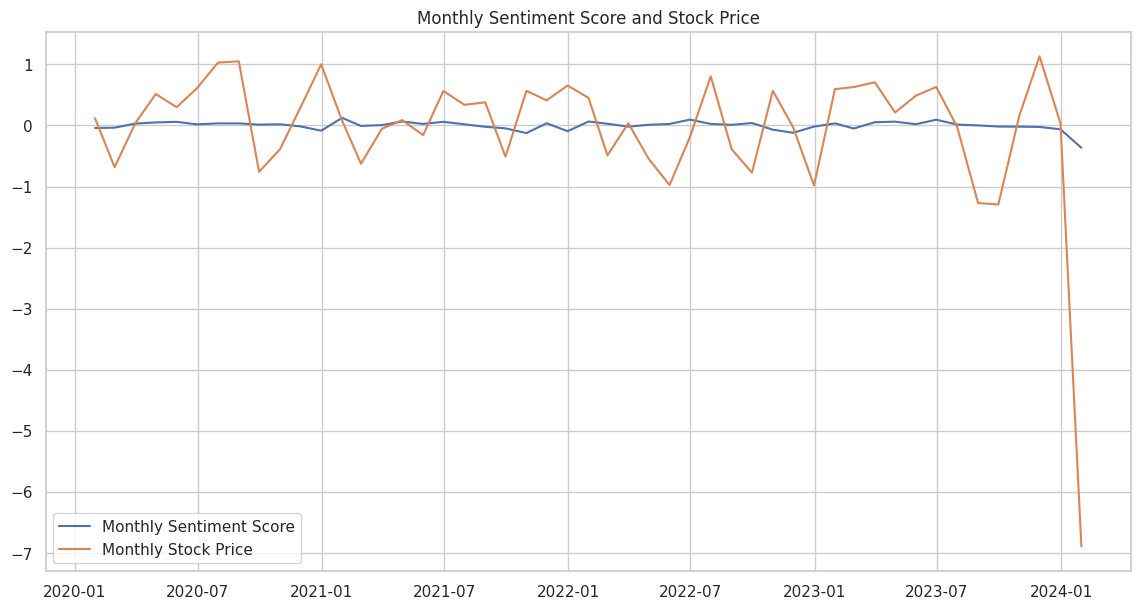

In [ ]:
import pandas as pd
import numpy as np

df_fin2 = df_finbert[['published_date','numeric_score', 'Stock_Price_Change']].copy()
df_fin2.set_index('published_date', inplace=True)

# Resample to weekly and monthly frequency, calculating the mean sentiment score
df_weekly = df_fin2.resample('W').mean()
df_monthly = df_fin2.resample('M').mean()

# If you want to keep other statistics like the count of headlines, you can do:
df_weekly_stats = df_fin2.resample('W').agg({'numeric_score': ['mean', 'count'], 'Stock_Price_Change': 'mean'})
df_monthly_stats = df_fin2.resample('M').agg({'numeric_score': ['mean', 'count'], 'Stock_Price_Change': 'mean'})


# Plot the aggregated sentiment scores and stock prices
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df_weekly.index, df_weekly['numeric_score'], label='Weekly Sentiment Score')
plt.plot(df_weekly.index, df_weekly['Stock_Price_Change'], label='Weekly Stock Price')
plt.title('Weekly Sentiment Score and Stock Price')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(df_monthly.index, df_monthly['numeric_score'], label='Monthly Sentiment Score')
plt.plot(df_monthly.index, df_monthly['Stock_Price_Change'], label='Monthly Stock Price')
plt.title('Monthly Sentiment Score and Stock Price')
plt.legend()
plt.show()


In [ ]:
df_weekly = df_weekly.dropna()
df_monthly = df_monthly.dropna()

# Granger Causality Test for Weekly Data
# We choose a lag value, say 4 (you can adjust based on your specific case)
print("Weekly Data Granger Causality Test:")
granger_test_weekly = grangercausalitytests(df_weekly[['numeric_score', 'Stock_Price_Change']], maxlag=4, verbose=True)

# Granger Causality Test for Monthly Data
print("\nMonthly Data Granger Causality Test:")
granger_test_monthly = grangercausalitytests(df_monthly[['numeric_score', 'Stock_Price_Change']], maxlag=4, verbose=True)

def interpret_granger_results(granger_results):
    for lag, test_result in granger_results.items():
        f_test_p_value = test_result[0]['ssr_ftest'][1]
        print(f'Lag {lag}: F-test p-value = {f_test_p_value}')

print("\nInterpreting Granger Causality Test Results for FinBERT monthly/weekly")
interpret_granger_results(granger_test_weekly)

print("\nInterpreting Granger Causality Test Results for FinBERT")
interpret_granger_results(granger_test_monthly)

Weekly Data Granger Causality Test:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9172  , p=0.3393  , df_denom=204, df_num=1
ssr based chi2 test:   chi2=0.9307  , p=0.3347  , df=1
likelihood ratio test: chi2=0.9286  , p=0.3352  , df=1
parameter F test:         F=0.9172  , p=0.3393  , df_denom=204, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4730  , p=0.2317  , df_denom=201, df_num=2
ssr based chi2 test:   chi2=3.0193  , p=0.2210  , df=2
likelihood ratio test: chi2=2.9974  , p=0.2234  , df=2
parameter F test:         F=1.4730  , p=0.2317  , df_denom=201, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6812  , p=0.1723  , df_denom=198, df_num=3
ssr based chi2 test:   chi2=5.2219  , p=0.1562  , df=3
likelihood ratio test: chi2=5.1565  , p=0.1607  , df=3
parameter F test:         F=1.6812  , p=0.1723  , df_denom=198, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Sentiment Aggregation - BERT

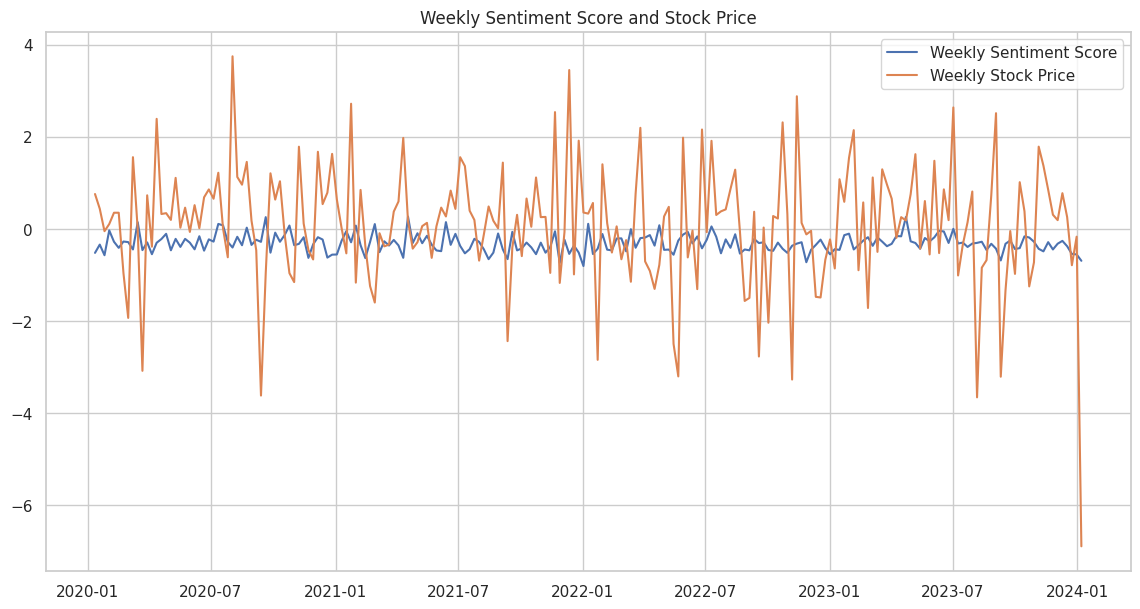

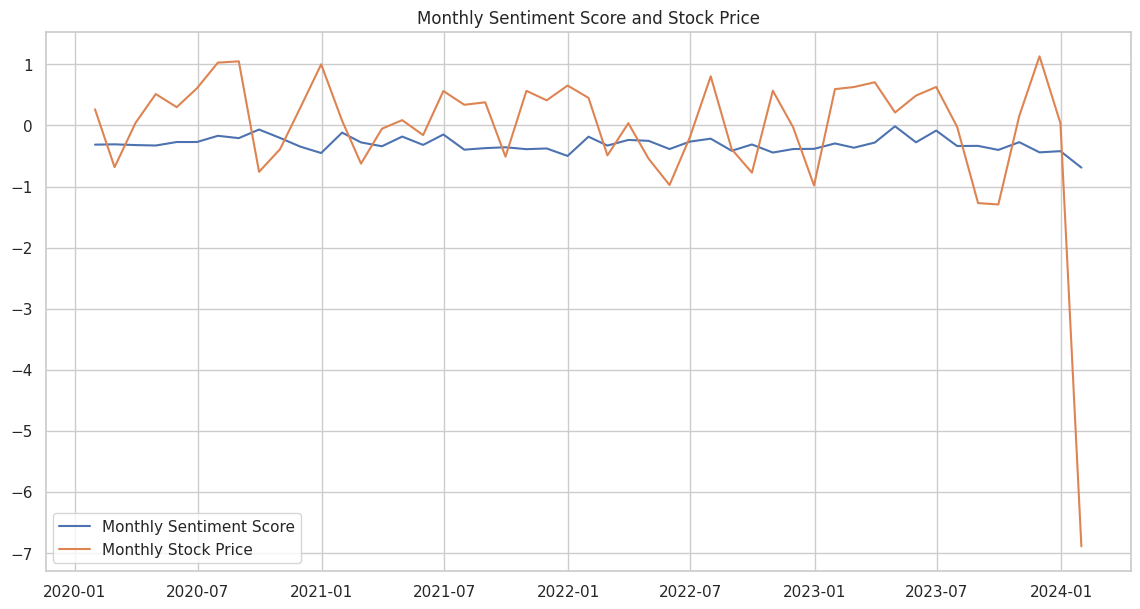

In [ ]:
import pandas as pd
import numpy as np

df_2 = df_bert[['published_date','numeric_score', 'Stock_Price_Change']].copy()
df_2.set_index('published_date', inplace=True)

# Resample to weekly and monthly frequency, calculating the mean sentiment score
df_weekly = df_2.resample('W').mean()
df_monthly = df_2.resample('M').mean()

# If you want to keep other statistics like the count of headlines, you can do:
df_weekly_stats = df_2.resample('W').agg({'numeric_score': ['mean', 'count'], 'Stock_Price_Change': 'mean'})
df_monthly_stats = df_2.resample('M').agg({'numeric_score': ['mean', 'count'], 'Stock_Price_Change': 'mean'})


# Plot the aggregated sentiment scores and stock prices
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df_weekly.index, df_weekly['numeric_score'], label='Weekly Sentiment Score')
plt.plot(df_weekly.index, df_weekly['Stock_Price_Change'], label='Weekly Stock Price')
plt.title('Weekly Sentiment Score and Stock Price')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(df_monthly.index, df_monthly['numeric_score'], label='Monthly Sentiment Score')
plt.plot(df_monthly.index, df_monthly['Stock_Price_Change'], label='Monthly Stock Price')
plt.title('Monthly Sentiment Score and Stock Price')
plt.legend()
plt.show()


In [ ]:
df_weekly = df_weekly.dropna()
df_monthly = df_monthly.dropna()

# Granger Causality Test for Weekly Data
# We choose a lag value, say 4 (you can adjust based on your specific case)
print("Weekly Data Granger Causality Test:")
granger_test_weekly = grangercausalitytests(df_weekly[['numeric_score', 'Stock_Price_Change']], maxlag=4, verbose=True)

# Granger Causality Test for Monthly Data
print("\nMonthly Data Granger Causality Test:")
granger_test_monthly = grangercausalitytests(df_monthly[['numeric_score', 'Stock_Price_Change']], maxlag=4, verbose=True)

def interpret_granger_results(granger_results):
    for lag, test_result in granger_results.items():
        f_test_p_value = test_result[0]['ssr_ftest'][1]
        print(f'Lag {lag}: F-test p-value = {f_test_p_value}')

print("\nInterpreting Granger Causality Test Results for BERT weekly")
interpret_granger_results(granger_test_weekly)

print("\nInterpreting Granger Causality Test Results for BERT monthly")
interpret_granger_results(granger_test_monthly)

Weekly Data Granger Causality Test:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5397  , p=0.4634  , df_denom=205, df_num=1
ssr based chi2 test:   chi2=0.5476  , p=0.4593  , df=1
likelihood ratio test: chi2=0.5469  , p=0.4596  , df=1
parameter F test:         F=0.5397  , p=0.4634  , df_denom=205, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4788  , p=0.6202  , df_denom=202, df_num=2
ssr based chi2 test:   chi2=0.9814  , p=0.6122  , df=2
likelihood ratio test: chi2=0.9791  , p=0.6129  , df=2
parameter F test:         F=0.4788  , p=0.6202  , df_denom=202, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4369  , p=0.7269  , df_denom=199, df_num=3
ssr based chi2 test:   chi2=1.3567  , p=0.7157  , df=3
likelihood ratio test: chi2=1.3522  , p=0.7168  , df=3
parameter F test:         F=0.4369  , p=0.7269  , df_denom=199, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
